## Прогнозирование уровня средней заработной платы в России 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
from itertools import product

# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

C:\Users\ribragimov\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##### 0. Считываем данные

In [3]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', index_col = ['month'],\
                   parse_dates = ['month'], dayfirst = True)

In [4]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


#### 1. Визуальный анализ ряда

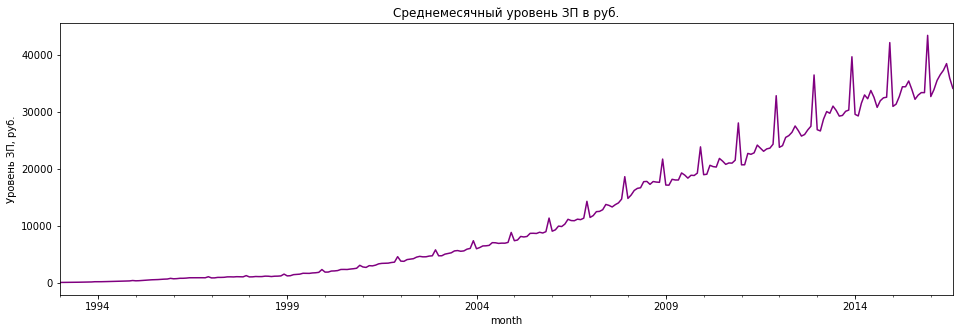

In [5]:
plt.figure(figsize = (16,5))
data.WAG_C_M.plot(color = 'purple')
plt.ylabel(u'Уровень ЗП, руб.')
plt.title(u'Среднемесячный уровень ЗП в руб.')
plt.show()

Уже из этого графика, видно что:
1. В данных присутсвует тренд
2. В данных присутсвует сезонная компонента
3. Дисперсия данных увеличивается со временем

Таким образом, рассматриваемый ряд явно не стационарный!

Давайте проверим это формально (с помощью теста Дики-Фуллера) и, кроме того, проведем STL декомпозицию ряда:  

In [6]:
print "Критерий Дики-Фуллера: ", sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]

Критерий Дики-Фуллера:  0.991849595485


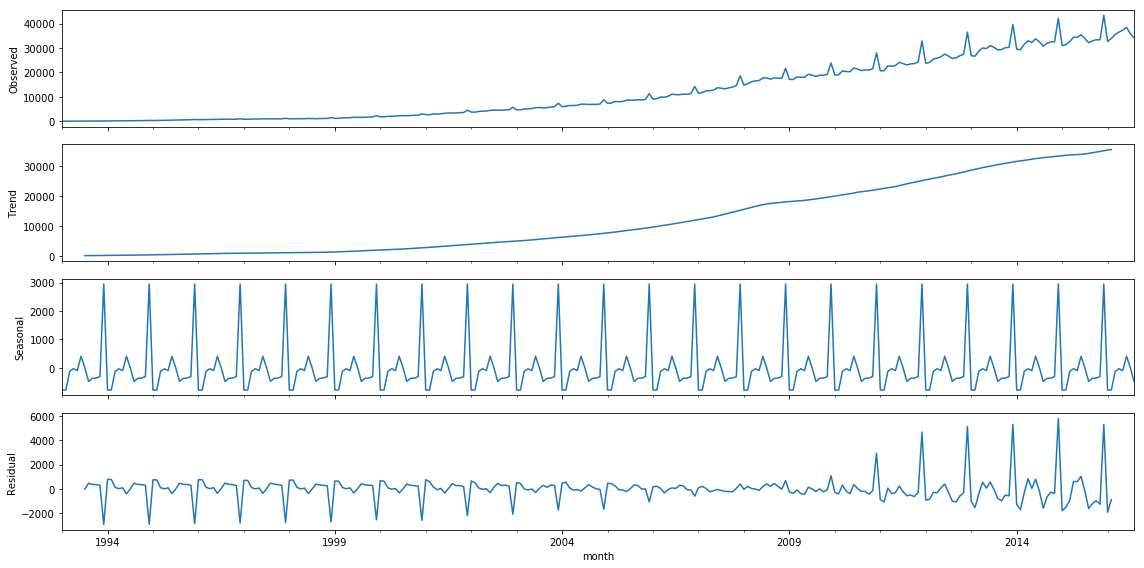

In [8]:
plt.figure(figsize(16, 8))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
plt.show()

##### Вывод 1: 
Ряд существенно не стационарный. Это подтверждается как с помощью визуального анализа, так и тестом Дики-Фуллера, который практически на любом уровне значимости не отвергает $H_{0}$, о нестационарности. 

#### 2. Стабилизация дисперсии 
Заметим что из предыдущего мы установили, что дисперсия ряда меняется со временем. Сделаем преобразование Бокса-Кокса для стабилизации дисперсии: 

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


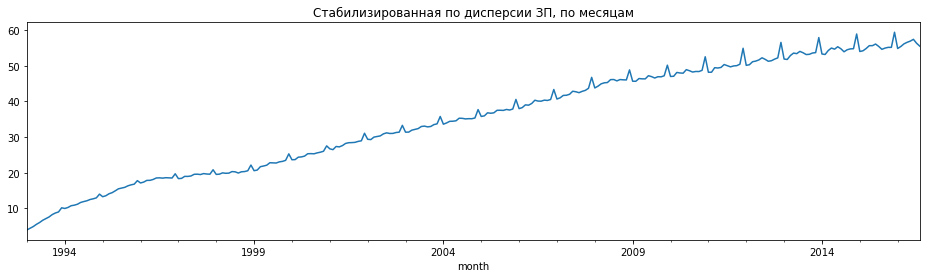

In [10]:
data['wage_box'], lmbda  = stats.boxcox(data.WAG_C_M)
print "Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1]

plt.figure(figsize = (16,4))
data.wage_box.plot()
plt.title(u'Стабилизированная по дисперсии ЗП, по месяцам')
plt.show()

Заметим, что ряд по прежнему не стационарен! (Подтверждается как тестом Дики-Фуллера, так и визуальным анализом)

#### 3. Стационарность: Выбор порядка дифференцирования 

Для начала, давайте попробуем с помощью сезонного дифференцирования избавится от сезонности в данных.

In [11]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1]

Критерий Дики-Фуллера: p=0.014697


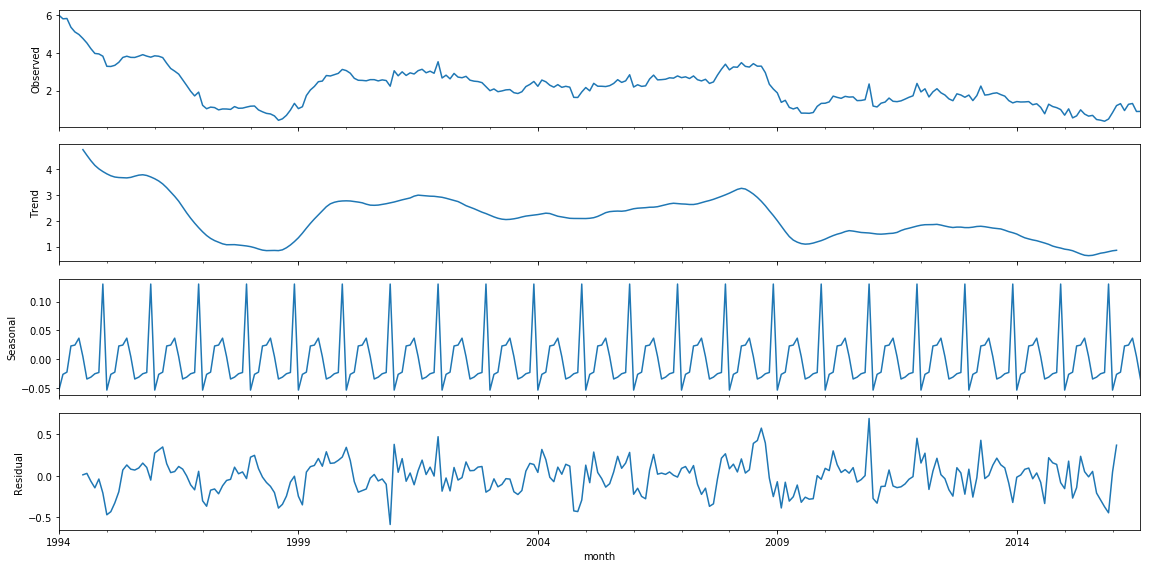

In [12]:
plt.figure(figsize = (16,8))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
plt.show()

Не смотря на то, что критерий Дики-Фуллера отвергает гипотезу о нестационарности (на 5% уровне значимости), мы видим что в преобразованных данных по прежнему остался тренд $\rightarrow$ Ряд по прежнему не стационарный. 

Для избавления от тренда, давайте попробуем добавить обычное дифференцирование (первые разности)

In [13]:
data['wage_box_diff1'] = data.wage_box_diff - data.wage_box_diff.shift(1)
print "Критерий Дики Фуллера: p=%e" % sm.tsa.stattools.adfuller(data.wage_box_diff1[13:])[1]

Критерий Дики Фуллера: p=5.203604e-08


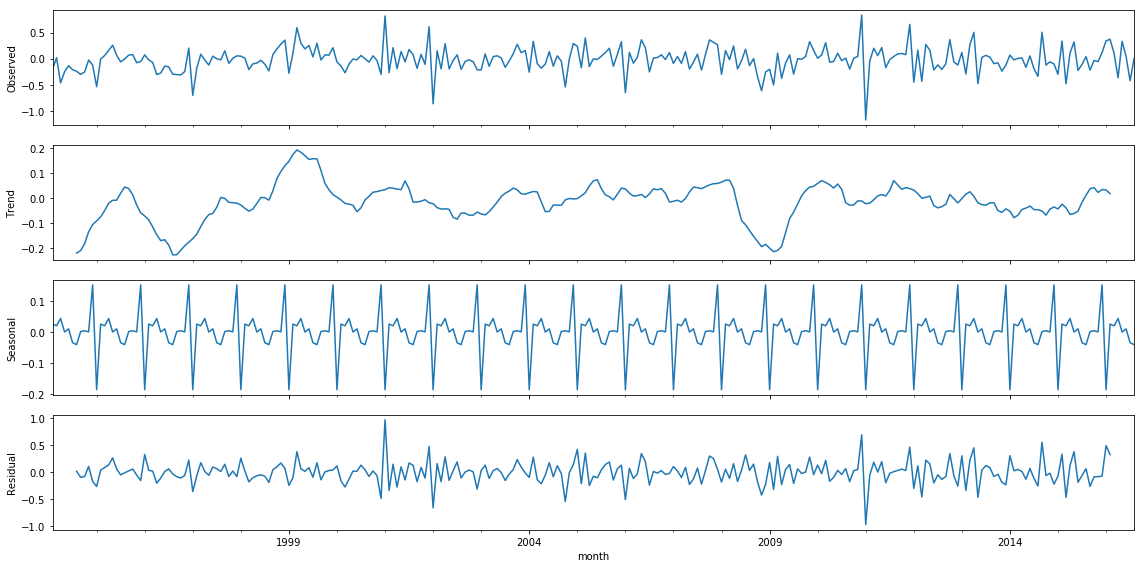

In [14]:
plt.figure(figsize = (16,6))
sm.tsa.seasonal_decompose(data.wage_box_diff1[13:]).plot()
plt.show()

Видим, что даже после первого дифференцирования, остались существенные неслучайные изломы (смены уровней) в тренде. Поэтому, первые разности не позволили нам полностью избавится от тренда!

Давайте попробуем еще раз продифференцировать ряд:

In [15]:
data['wage_box_diff2'] = data.wage_box_diff1 - data.wage_box_diff1.shift(1)
print "Критерий Дики Фуллера: p=%e" % sm.tsa.stattools.adfuller(data.wage_box_diff2[14:])[1]

Критерий Дики Фуллера: p=1.015956e-13


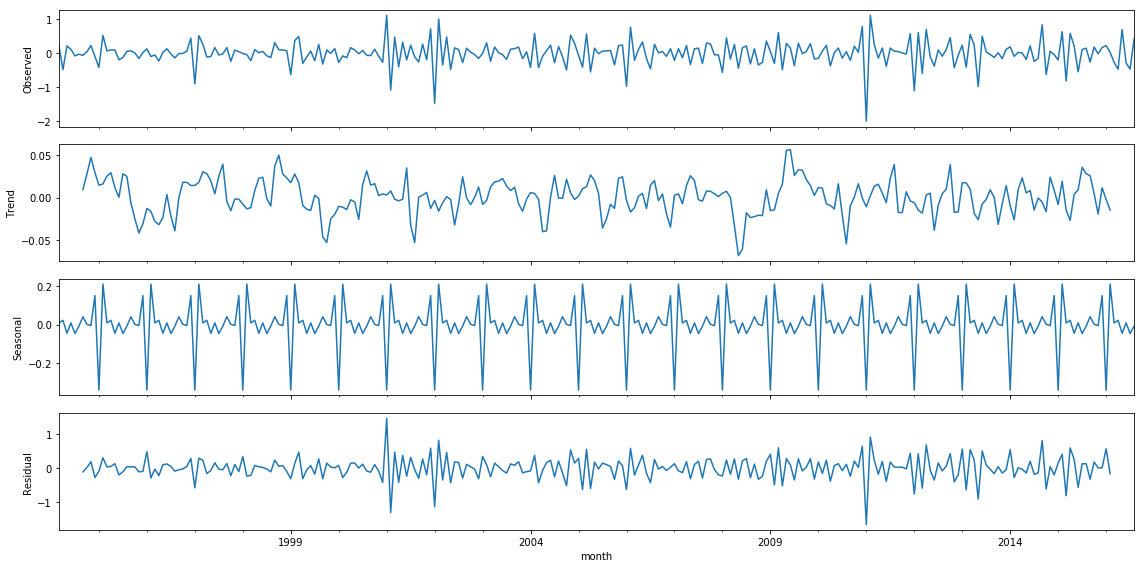

In [16]:
plt.figure(figsize = (16,6))
sm.tsa.seasonal_decompose(data.wage_box_diff2[14:]).plot()
plt.show()

Видим, что добаление еще одного дифференцирования помогло в избавлении от тренда. Кроме того, критерий Дики-Фуллера для такого ряда уверенно отвергает нулевую гипотезу в пользу стационарности. 

##### Вывод 3: d = 2, D = 1
Для стационаризации ряда, будем использовать сезонное дифференцирование с последующими 2мя обычными дифференцированиями.

#### 4. Выбор начальных приближений (p, q, P, Q)

Для инициализации настройки гиперпараметров SARIMA модели, воспользуемся анализом графиков автокорреляции и частичной автокорреляции.

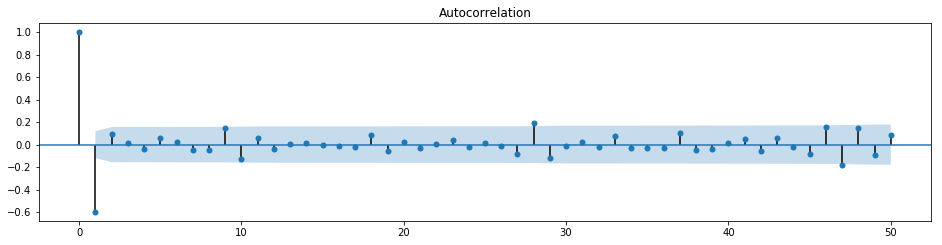

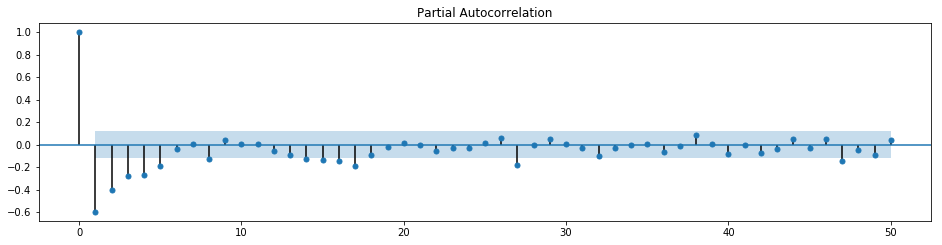

In [17]:
plt.figure(figsize = (16,8))

ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[14:], ax = ax1, lags = 50)
plt.show()

ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[14:], ax = ax2, lags = 50)
plt.show()

1. Из графика для автокорреляции видим, что следует выбрать: $Q = 0; q = 1$ (при q = 28, слишком большое кличество лагов придется включать в модель. Т.е. модель станет чересчур сложной, что не желательно)
2. Из графика для частичной автокорреляции и здравого смысла видим, что следует выбрать: $P = 0; p = 5$

##### Вывод 4.
Начальное приближение p = 5; P = 0; q = 1; Q = 0.

#### 5. Подбор модели:
Будем осуществлять последовательный перебор по всем гиперпараметрам модели. Лучшой моделью будем считать ту, у которой минимальное значение криетрия AIC.

In [18]:
#Инициализируем гиперпараметры
p_init = 5
P_init = 0
q_init = 1
Q_init = 0
d = 2
D = 1

In [35]:
#Создаем все возможные комбинации гиперпараметров
parameters = product(range(0, p_init+1), range(0, q_init+1), range(0,P_init+1), range(0,Q_init+1))
parameters_list = list(parameters)

In [36]:
import warnings

In [37]:
#Обучаем на каждой комбинации гиперпараметров модель SARIMA  
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))


In [38]:
results = pd.DataFrame(results, columns = ['parameters', 'aic'])
results.sort_values(by = 'aic')

,parameters,aic
10,"(5, 1, 0, 0)",4.800794
2,"(1, 1, 0, 0)",7.646883
6,"(3, 1, 0, 0)",8.442077
4,"(2, 1, 0, 0)",9.186740
0,"(0, 1, 0, 0)",12.067277
9,"(5, 0, 0, 0)",17.018153
8,"(4, 1, 0, 0)",17.151917
7,"(4, 0, 0, 0)",24.526880
5,"(3, 0, 0, 0)",42.830457
3,"(2, 0, 0, 0)",62.235728


##### Вывоб 5:
Лучшая по AIC SARIMA модель - это модель с параметрами (p = 5, d = 2, q = 1) $\times$ (P = 0, D = 1, Q = 0)

Рассмотрим саммари модели:

In [39]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(5, 2, 1)x(0, 1, 0, 12)   Log Likelihood                   4.600
Date:                            Tue, 05 Dec 2017   AIC                              4.801
Time:                                    21:26:55   BIC                             30.344
Sample:                                01-01-1993   HQIC                            15.041
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.052     -2.876      0.004      -0.253      -0.048
ar.L2          0.0661      0.070      0.944      0.345      -0.071       0.203
ar.L3          0.1154      0.064      1.810      0.070      -0.010       0.240
ar.L4          0.1106      0.069      1.609      0.108      -0.024       0.245
ar.L5          0.1455      0.076      1.908      0.056      -0.004       0.295
ma.L1         -0.9991      0.129     -7.753      0.000      -1.252      -0.747
sigma2         0.0556      0.007      7.799      0.000       0.042       0.070
===================================================================================
Ljung-Box (Q):                       48.63   Jarque-Bera (JB):                61.41
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.06
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 6. Анализ остатков

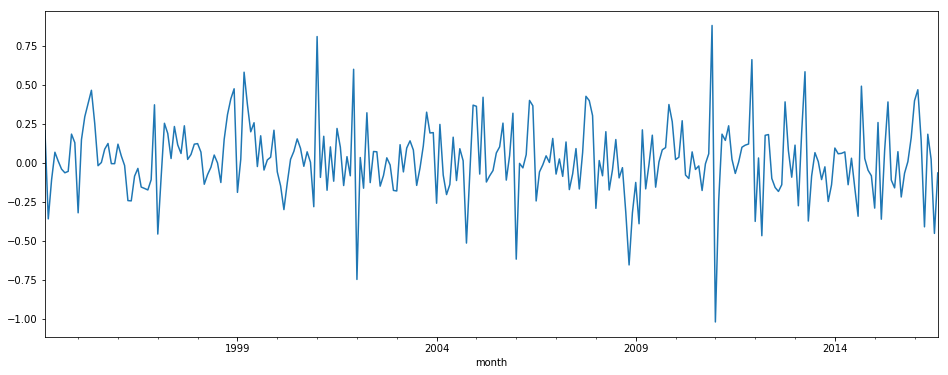

In [40]:
plt.figure(figsize = (16,6))
best_model.resid[14:].plot()
plt.show()

Визуальный анализ позволяет заключить, что получившиеся остатки несмещенны, а их дисперсия держится примерно на одном уровне. Т.е. визуальный анализ не идентифицирует каких-то явных отклонений от стационарности.

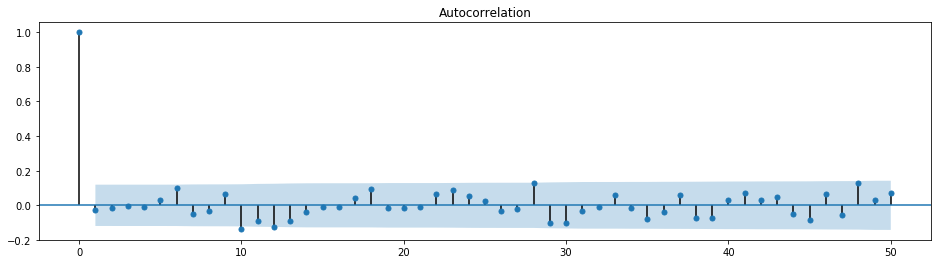

In [41]:
_,ax = plt.subplots(1,1, figsize = (16,4))
sm.graphics.tsa.plot_acf(best_model.resid[14:], lags = 50, ax = ax)
plt.show()

Анализ автокорреляций остатков позволяет заключить, что мы не можем отвегрнуть гипотезу об отсутствии автокорреляции. (Заметим, что по Q критерию Льюнга-Бокса мы получаем аналогичный результат)

In [42]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

Критерий Стьюдента: p=0.094046
Критерий Дики-Фуллера: p=1.191958e-29


Более формальные критерии Стьюдента и Дики-Фуллера также свидетельствуют в пользу, соотвественно, несмещенности и стационарности остатков!

##### Вывод 6:
Анализ остатков модели, позволяет сделать вывод о корректности полученной модели предсказания заработных плат.

##### Исходный ряд и ряд, построенный по полученной модели

In [43]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

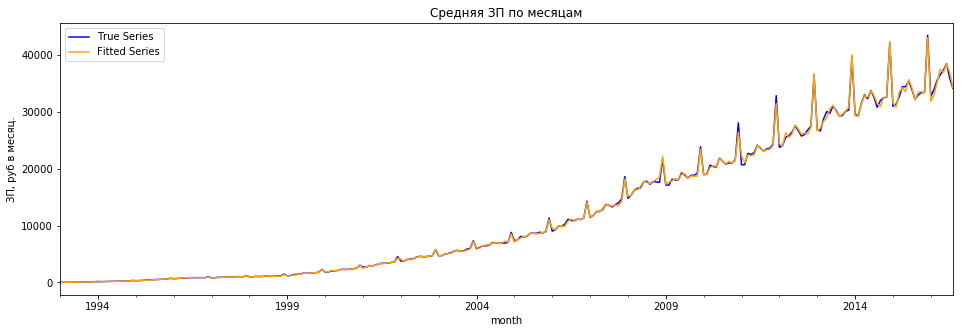

In [44]:
data['wage_model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize = (16,5))
data['WAG_C_M'].plot(color = 'blue', label = 'True Series')
data['wage_model'].plot(color = 'orange', label = 'Fitted Series')
plt.legend()
plt.ylabel(u'ЗП, руб в месяц.')
plt.title(u'Средняя ЗП по месяцам')
plt.show()

##### Вывод:
Видим, что наша модель, действительно хорошо приближает наблюдаемый ряд.

#### 7. Прогнозирование зарплат на 2 года вперед и сравнение с реально реализовавшимися зарплатами

In [47]:
#Вычисляем прогноз и добавляем к новому DataFrame-у
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0]+ 24 - 1), lmbda)

In [48]:
#Скачиваем с сайта http://sophist.hse.ru/exes/tables/WAG_M.htm реально пронаблюдавшиеся зарплаты и создаем новый DataFrame 
real_wage = [35843.0, 35749.0, 36195.0, 47554.0 ,35369.0, 35845.0, 38483.0, 39839.0, 40229.0, 42042.0, 
             38619.0, 37140.0, 38083.0, 38275.0]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, len(real_wage))]
data_real = pd.DataFrame(real_wage, index = date_list, columns = ['real_wage'])

In [49]:
#Объединяем два полученных DataSet-a
data3 = pd.concat([data2, data_real], axis = 1)

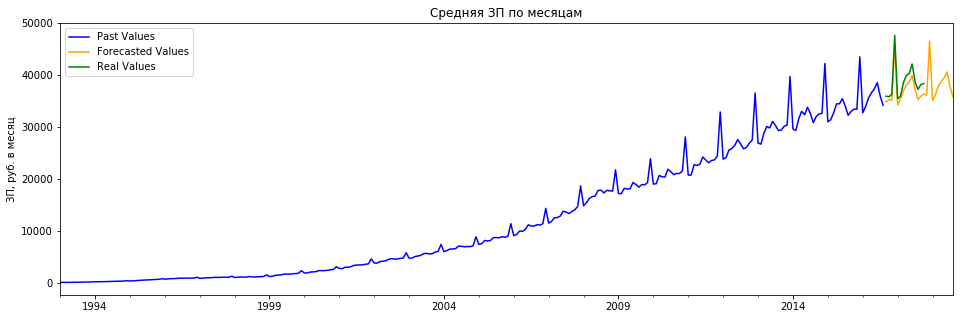

In [52]:
#Рисуем исходный ряд, прогнозируемые значения ряда и реально реализовавшиеся значения
plt.figure(figsize(16,5))
data3.WAG_C_M.plot(color = 'blue', label = 'Past Values')
data3.forecast.plot(color= 'orange', label = 'Forecasted Values')
data3.real_wage.plot(color = 'green', label = 'Real Values')
plt.ylabel(u'ЗП, руб. в месяц')
plt.legend()
plt.title(u'Средняя ЗП по месяцам')
pylab.show()

##### Вывод 7:
Видим, что наша модель отлично уловила форму зависимости средней зарплаты от месяца. И, не смотря на то, что предсказанные и реализовавшиеся значения отличаются, это отличие, особенно на небольшом промежутке прогнозирования, не очень значительно.